# Set up

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# make sure the a bot that's not a bot is in your drive's root folder (do not change this line)
%cd "/content/drive/MyDrive/bot-that's-not-a-bot"

/content/drive/.shortcut-targets-by-id/1JM2zeyfEBunPH1XKNRbCKtL__BLZXR8Y/bot-that's-not-a-bot


## Download packages

In [3]:
!pip install chatette --quiet
# show progress bars while installation and downloading 
!pip install tqdm  >> /dev/null
# the original implementation given in research paper is not compatible with TensorFlow 2. The bert-for-tf2 package solves this issue.
!pip install bert-for-tf2 >> /dev/null
# install sentencepiece tokenizer for making tokens out of sentences
!pip install sentencepiece >> /dev/null
!pip install transformers >> /dev/null
!pip install tensorflow==2.3.4 >> /dev/null

## Imports

In [4]:
import json
# for creating artificial data
import chatette
# making directories, math operations
import os
import math
import datetime
# show progress bars in the notebook itself
from tqdm import tqdm
# data manipulation in dataframe and array
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
# for setting seed for the random module
import random
# for evaluation
from sklearn.metrics import accuracy_score

In [8]:
# import the bert model and model layer 
# also the bert tokenizer for text pre processing
import bert
# we can change the layers downloaded from here
from bert import BertModelLayer
# useful for loading necessary files from data
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

# import the bart-large model
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline
# from torch.nn import functional as F
# import torch

# data visualization at the time of data import and model metrics
import seaborn as sns
# we can set the parameters for each plot 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
# model metrics to be defined 
from sklearn.metrics import confusion_matrix, classification_report


# showing the plots in the notebook itself
%matplotlib inline
# retina is a style shape
%config InlineBackend.figure_format='retina'
# setting the visualizing settings first hand
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# getting the colors we need for plots
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
# define the color palette
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# size can be set accordingly
rcParams['figure.figsize'] = 12, 8



## Download model zip

In [12]:
# download the pre trained bert model in the form of a zip file
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip -O '/tmp/uncased_L-12_H-768_A-12.zip'
# unzipping the file having model
# this is having all the checkpoints , vocab.text for tokenizer , configurations for model
!unzip '/tmp/uncased_L-12_H-768_A-12.zip' -d '/tmp/uncased_L-12_H-768_A-12'
# make a folder named model for moving all the stuff 
os.makedirs("/tmp/model", exist_ok=True)
! rm -r '/tmp/model'
# moving the stuff from bert to model folder 
!mv '/tmp/uncased_L-12_H-768_A-12' '/tmp/model'
# specify the model name 
bert_model_name="uncased_L-12_H-768_A-12"
# specify where the  check point directory is 
bert_ckpt_dir = os.path.join("/tmp/model/", bert_model_name)
# specify the checkpoint file itself
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
# specify the configuration file 
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json") 

'/tmp/uncased_L-12_H-768_A-12.zip': No such file or directory
unzip:  cannot find or open /tmp/uncased_L-12_H-768_A-12.zip, /tmp/uncased_L-12_H-768_A-12.zip.zip or /tmp/uncased_L-12_H-768_A-12.zip.ZIP.
rm: cannot remove '/tmp/model': No such file or directory
mv: cannot stat '/tmp/uncased_L-12_H-768_A-12': No such file or directory


In [13]:
!ls

'tmp'
GUI.ipynb
Intent_rec_project (PyTorch).ipynb
Intent_rec_project (TensorFlow).ipynb
tmp


## Download OOS Dataset

In [7]:
#Download clinc_oos dataset from https://huggingface.co/datasets/viewer/?dataset=clinc_oos
!pip install datasets --quiet
from datasets import load_dataset

## Helper Functions

In [8]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes):
  # create a confusion matrix and chart it
  cm = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  # using a heatmap from seaborn to visualize the confusion matric
  hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');

In [11]:
def generate_class_weights(y, classes):
  '''
  Args: 
    y (int array): (n_samples,) from 0, ..., n_classes
  '''
  weights = len(y) / (len(classes) * np.bincount(y))
  class_weights = {}
  for i, class_label in enumerate(classes):
    class_weights[i] = weights[i]
  return class_weights

## Set Device and Random Seed

In [12]:
RANDOM_SEED = 2021
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) 
set_seed(seed=RANDOM_SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


# Generate Intent Dataset


In [13]:
with open("/tmp/text.txt", "w") as file:
  file.write("""
%[food](500)
    I would like some @[food?name] @[food_type?!name] [please?]
    [I’m|I am] ~[hungry]
    ~[need] @[food]
    ~[can_you?] ~[bring] some [food|water] [please?]
    ~[can_you?] [help|help me] get some [food|water] [please?] 
    ~[can_you?] get some [food|water] [please?]   
    [When|What time] is @[foodtime]  
    ~[can_I?] have @[food_type] for @[foodtime]
    ~[bring] @[food] 
    ~[bring] @[food_type?name] @[drink_type?!name]
    Am I getting ~[amount?] @[food]
    Am I getting ~[amount?] @[food_type?name] @[drink_type?!name]
    Do you know how to get @[food]
    Do you know how to get @[food_type?name] @[drink_type?!name]
    ~[ask_exist] any more @[food_type?name] @[drink_type?!name]
    I ~[desire] to eat @[food_type]
    I ~[desire] to drink some @[food_type]
    ~[ask_able] I eat some @[drink_type]
    ~[ask_able] I drink some @[drink_type]?
 
%[send_text](500)
   ~[can_you?name] ~[can_I?!name] send [a?] ~[text]    
   ~[can_you?name] ~[can_I?!name] send [a?] ~[text] to @[person?name/80%] @[name?!name]
   ~[can_you?name] ~[can_I?!name] ~[text] @[person?name/80%] @[name?!name]
   ~[text] @[person?name/80%] @[name?!name]
   [please?] send a ~[text] to @[person?name/80%] @[name?!name]
 
%[make_call](500)
   ~[can_you?name] ~[can_I?!name]  make a ~[call]
   ~[can_you?name] ~[can_I?!name]  make a ~[call] to @[person?name/80%] @[name?!name]
   ~[can_you?name] ~[can_I?!name] call @[person?name/80%] @[name?!name]
   ~[can_you?name] ~[can_I?!name] make a ~[call] to @[name]
   put @[person?name/80%] @[name?!name] on the phone   
   ~[can_you?] ~[call] @[person?name/80%] @[name?!name] 
   put @[person?name/80%] @[name?!name] on the phone
   [please?] call @[person?name/80%] @[name?!name]
 
%[get_help](500)
    ~[ask_able] [anyone|someone] ~[help_action] [me?]
    ~[can_you?] [call|ask for] ~[article?] @[emergency_person]
    got a ~[situation]
    I’m having a ~[situation]
    there is a ~[situation]
    help [please?]
    [I?] [am in need of|require] [help|assistance]
    [please?] call [in?] ~[article] @[emergency_person] 
    I [need|require] [help_from?] ~[article] @[emergency_person]
    [Please?] get ~[article] @[emergency_person]
    [Please?] call Dr. @[last_name]
    [Please?] call Nurse @[name?name] @[last_name?!name]
    
%[visitors](500)
    when @[verb person] coming [to visit?] [me?]
    ~[ask_exist] any visitors @[date?]
    @[verb person] visiting [me?] @[date?]
    is @[name] visiting [me?]
    when are visiting hours?
    do I have [any?] visitors @[date?]?
    [Who’s|who is] [coming|going] to visit [me?] @[date?]
    is @[name] going to visit [me?] @[date?]
    when will @[name] visit [me?]
    is anyone coming to visit @[date?]?
    [Who’s|who is] coming @[date?]
 
~[amount]
    Any
    Some
 
~[article]
   the
   a
   my 
 
~[ask_able]
   can
   could
   would
   will
   may
 
~[ask_exist]
   is there
   are there
 
~[bring]
   Bring
   Bring me
   Get me
 
~[call]
   call
   phone call
 
~[can_I]
   can I
   could I
 
~[can_you]
   can you
   could you
 
@[date]
   today
   tomorrow
   this week
   next week
   this month
 
~[desire]
   would like
   Want
 
@[drink_type]
   Soda
   Juice
   Milk
   Coffee
   Tea
 
@[emergency_person]
   doctor
   nurse
   caregiver
 
@[food]
   Food
   water
   
@[foodtime]
   breakfast
   mealtime
   lunchtime
   lunch
   dinner
   snack time
 
@[food_type]
   Tacos
   Lasagna
   Sandwich
   Pasta
   Chips
   Crackers
   Chocolate
   Cookies
  
~[help_action]
   help
   assist
   come
   come help
 
~[help_from]
   help from
   attention from
   assistance from
 
~[hungry]
   hungry
   starving
   thirsty
 
@[last_name]
   Smith
   Johnson
   Williams
   Brown
   Jones
   Garcia
   Miller
   Davis
   Rodriguez
 
@[name]
   william
   olivia
   emma
   ava
   charlotte
   sophia
   amelia
   isabella
   mia
   evelyn
   harper
   camila
   gianna
   abigail
   luna
   ella
   elizabeth
   sofia
   emily
   avery
   mila
   scarlett
   eleanor
   madison
   layla
   penelope
   aria
   chloe
   grace
   ellie
   nora
   hazel
   zoey
   riley
   victoria
   lily
   aurora
   violet
   nova
   hannah
   emilia
   zoe
   stella
   everly
   isla
   leah
   lillian
   addison
   willow
   lucy
 
~[need]
   need
   Bring
   call for
   want
   get me
 
@[person]
   mom
   my mom
   my dad
   dad
   my brother
   my family
   my sister
 
@[pronoun]
   he
   she
   him
   her
   they
   Them
 
~[situation]
   problem
   emergency
   situation
   Issue
 
~[text]
   text
   message
   text message
   DM
   
@[verb person]
   is mom
   is my mom
   is my dad
   is dad
   is my brother
   is my sister
   is my family
   are my parents
   are visitors
   are the visitors
   are my friends

   """)


# Preprocess dataset

Preprocess OOS dataset

In [14]:
dataset = load_dataset(
   'clinc_oos', 'small')

#Takes 5 examples from the first 100 intents in the training dataset
df = pd.DataFrame(dataset["train"])
dict_result = {"intent":"out_of_scope", "text":[]}
for i in range(100):
  temp_list = list(df[df["intent"] == i]["text"][:5].values)
  for j in temp_list:
    dict_result["text"].append(j)
OOS_df = pd.DataFrame(dict_result)
OOS_df['text'] = OOS_df['text'].apply(lambda x: x.lower())

Reusing dataset clinc_oos (/root/.cache/huggingface/datasets/clinc_oos/small/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


In [15]:
!python -m chatette '/tmp/text.txt' -o '/tmp/output'
file_data = open("/tmp/output/train/output.json")
data = json.load(file_data)

orig_intent = np.empty([len(data['rasa_nlu_data']['common_examples']), 1], dtype=object)
orig_text = np.empty([len(data['rasa_nlu_data']['common_examples']), 1], dtype=object)
for i, item in enumerate(data['rasa_nlu_data']['common_examples']):
  orig_intent[i] = item['intent'].lower()
  orig_text[i] = item['text'].lower()

df = pd.DataFrame(np.concatenate([orig_text, orig_intent], axis=1), columns=['text', 'intent'])
# strip underscore of the intents
df['intent'] = df['intent'].apply(lambda x: x.replace('_', ' '))
# combine generated intent dataset with OOS dataset
df = pd.concat([df, OOS_df], axis=0)
df = df.sample(frac=1).reset_index(drop=True)


# taking unique intents and convert them to list 
classes = sorted(df['intent'].unique().tolist())
classes_without_oos = classes.copy()
classes_without_oos.remove('out_of_scope')
classes_gate = ['in_scope', 'out_of_scope']
print(classes)
print(classes_without_oos)
print(classes_gate)

train_frac = 0.7
valid_frac = 0
test_frac = 0.3
assert train_frac + valid_frac + test_frac <= 1, 'make sure train_frac + valid_frac + test_frac <= 1'

train_valid_split = int(train_frac * len(df))
valid_test_split = train_valid_split + int(valid_frac * len(df))
train = df.iloc[:train_valid_split]
valid = df.iloc[train_valid_split:valid_test_split]
test = df.iloc[valid_test_split: int(test_frac * len(df)) + valid_test_split]

def convert_in_scope(x):
  if x != 'out_of_scope':
    x = 'in_scope'
  return x

df_gate = df.copy()
df_gate['intent'] = df_gate['intent'].apply(convert_in_scope)
train_gate = df_gate.iloc[:train_valid_split]
valid_gate = df_gate.iloc[train_valid_split:valid_test_split]
test_gate = df_gate.iloc[valid_test_split: int(test_frac * len(df)) + valid_test_split]

train_without_oos = train[train['intent'] != 'out_of_scope']
valid_without_oos = valid[valid['intent'] != 'out_of_scope']
test_without_oos = test[test['intent'] != 'out_of_scope']

max_seq_len = 30

Executing Chatette with random seed 'NEXoCm'.
[DBG] Parsing file: /tmp/text.txt

[WARN] Folder '/tmp/output' already exists.

Overwrite the whole folder? [y/n] t

[DBG] Aborting generation. Exiting without any change.
['food', 'get help', 'make call', 'out_of_scope', 'send text', 'visitors']
['food', 'get help', 'make call', 'send text', 'visitors']
['in_scope', 'out_of_scope']


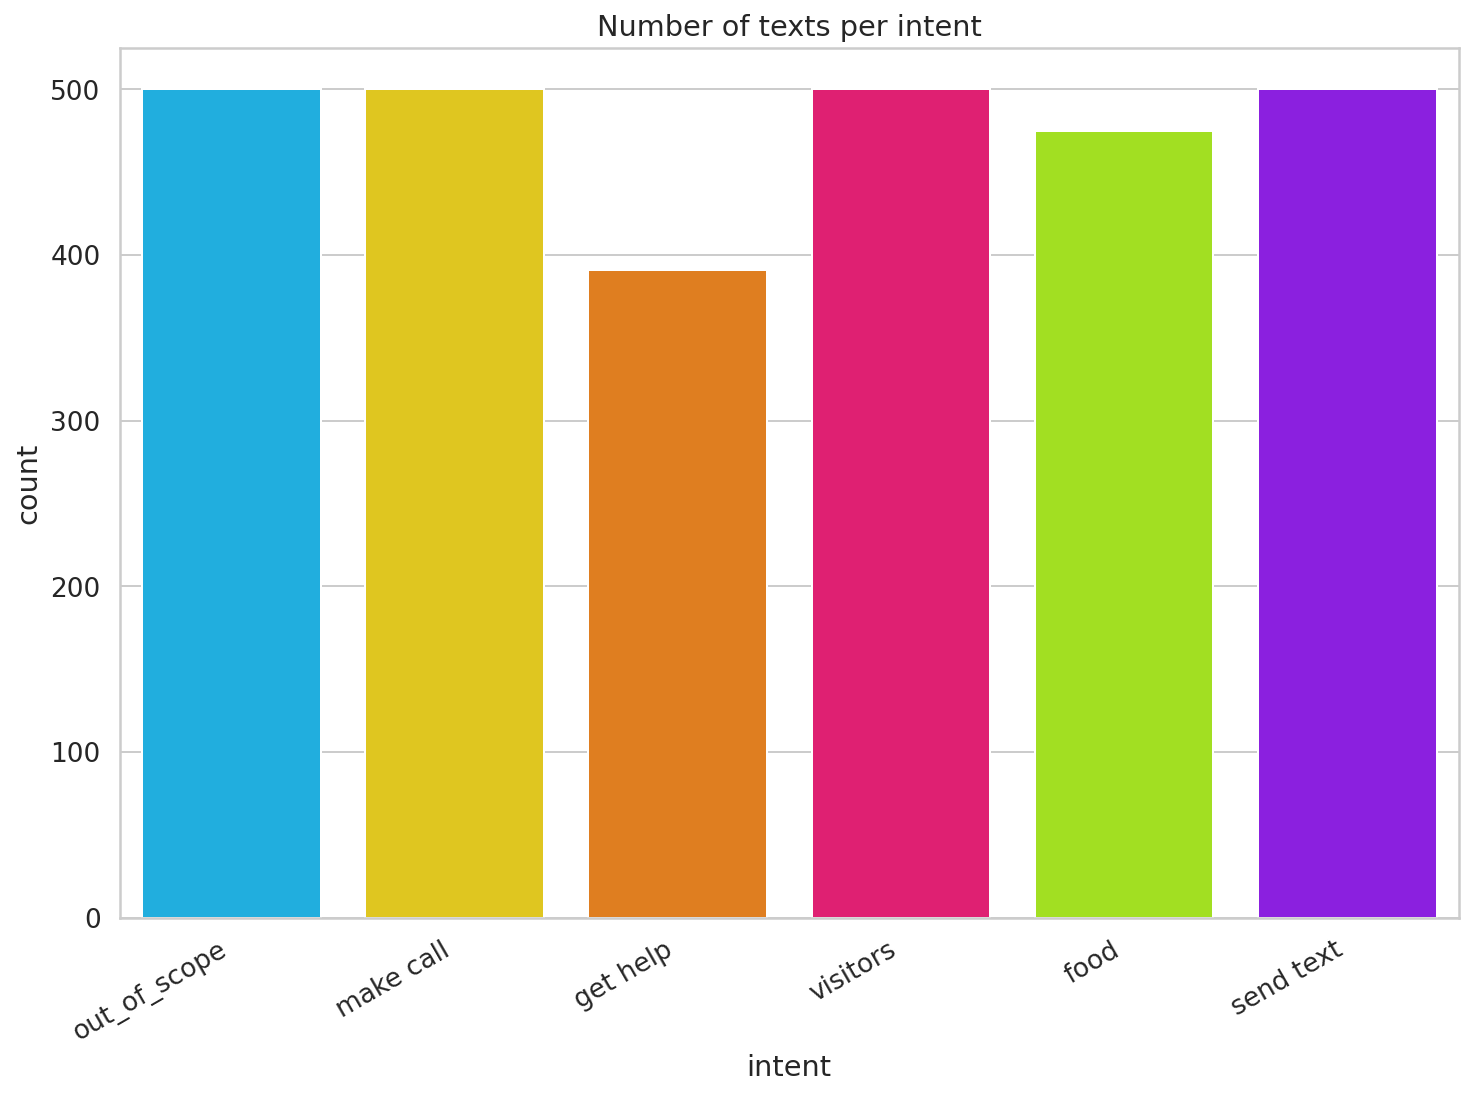

In [16]:
# let's check how the datset looks , if it is imbalanced or not
# making a chart to see how many texts are for each of the seven intents
chart = sns.countplot(x=df['intent'], palette=HAPPY_COLORS_PALETTE)
# setting title of the chart
plt.title("Number of texts per intent")
# setting labels to the bottom at an angle of 30 degrees
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right'); 

In [17]:
# pre processing in which we have to use the tokenizer
# for getting tokens so that we can feed the model
# creating a class which is a little generic for doing our tokenizing process
class IntentDetectionData:
  # we had two columns to which have given names according to use
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"
  '''
  creating constructor having train data , test data , tokenzier , max_seq_len because NLP tasks work on a fixed number of elements 
  the data set we are having has different lengths of sequences , that's why we have to do same length for all  , either we can cut the sequence 
  lengths to some minimal point or we can add padding up to the maximum existing 
  ''' 
  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=30, max_seq_len_force=True):
    self.tokenizer = tokenizer
    # setting initial to 0
    self.max_seq_len = 0
    self.classes = classes
    '''
    create train_X and train_Y 
    train_X will have the vectors , train_Y will have the target labels 
    same we will do for the testing part
    '''
    # train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    # we gave to set the variables to which we can map values using the above function
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
    # setting the actual value to max_seq_len
    if max_seq_len_force:
      self.max_seq_len = max_seq_len
    else:
      self.max_seq_len = min(self.max_seq_len, max_seq_len)
    # adding padding in the following line
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
  def _prepare(self, df):
    # initialising two empty arrays
    x, y = [], []
    # iterate over each row and use tqdm to visualize that
    for _, row in tqdm(df.iterrows()):
      # extracting the seq. and labels
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      # create an object named token and initialise it
      tokens = self.tokenizer.tokenize(text)
      # adding two special tokens which will surround each token 
      # from front and back 
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      # convert the token ids to numbers using a helper
      # function already provided for feeding
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      # calculate the length of seq. by taking max. 
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      # appends the token ids to x
      x.append(token_ids)
      # indexes of labels to the y
      y.append(self.classes.index(label))
    # returning these in the form of nparrays
    return np.array(x), np.array(y)
  # takes the ids and not the tokens itself
  def _pad(self, ids):
    # create an empty list again
    x = []
    # iterating over each id
    for input_ids in ids:
      # we have to cut the longer seq. , self.max_seq_len - 2 
      # because two positions are reserved for the special tokens as mentioned before
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      # adding padding to the smaller ones
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      # appending  
      x.append(np.array(input_ids))
    return np.array(x)

# Modeling

## Few-shot Learning

### Bert

In [18]:
# use tokenizer which expects a vocabulary file, 
# we have this file already in our data
bert_tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "/tmp/model/uncased_L-12_H-768_A-12/vocab.txt"))

In [19]:
def create_model(max_seq_len, bert_ckpt_file, bert_config_file):
  # open the config file using tensorflow for reading
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
  # create the input layer with seq. len as input       
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output) 
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))
  load_stock_weights(bert, bert_ckpt_file)
  return model

In [20]:
def get_bert_predictions(sentences, classes, tokenizer=bert_tokenizer):
  pred_tokens = map(tokenizer.tokenize, sentences)
  pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
  pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
  pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
  pred_token_ids = np.array(list(pred_token_ids))
  predictions = bert_model.predict(pred_token_ids).argmax(axis=-1).astype(int)
  predictions =[classes[idx] for idx in predictions]
  return predictions

## Zero-shot Learning

### Sentence-Bert

In [21]:
def get_sentence_bert_predictions(sentence, classes, tokenizer, model):
  '''
  Args:
    sentence: string
    classes: list of labels
  Returns:
    prediction: string, one of the class labels
  '''

  labels = classes

  # run inputs through model and mean-pool over the sequence
  # dimension to get sequence-level representations
  inputs = tokenizer.batch_encode_plus([sentence] + labels,
                                      return_tensors='pt',
                                      padding=True)

  with torch.no_grad():
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    output = model(input_ids, attention_mask=attention_mask)[0]
    sentence_rep = output[:1].mean(dim=1)
    label_reps = output[1:].mean(dim=1)

  # now find the labels with the highest cosine similarities to
  # the sentence
  similarities = F.cosine_similarity(sentence_rep, label_reps)
  closest = similarities.argsort(descending=True)

  
  # for ind in closest:
  #     print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')
  return np.array(labels)[closest][0]

In [22]:
sentence_bert_tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
sentence_bert_model = AutoModel.from_pretrained('deepset/sentence_bert')

Some weights of the model checkpoint at deepset/sentence_bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Bart-Large

In [23]:
def get_bart_large_predictions(sentences, classes, tokenizer, model):
  zsc = pipeline(task='zero-shot-classification', tokenizer=tokenizer, model=model)
  return zsc(sequences=sentences, candidate_labels=classes, multi_label=False)

In [24]:
bart_large_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
bart_large_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')

## Pipelining for OOS

### One-Stage Bert

In [25]:
# compiling the model 
data = IntentDetectionData(train, test, bert_tokenizer, classes, max_seq_len=max_seq_len)
bert_model = create_model(data.max_seq_len, bert_ckpt_file, bert_config_file)
bert_model.compile(
  # optimizer is Adam with learning rate 0.00001 ,  this is recommended by authors of bert model paper
  optimizer=keras.optimizers.Adam(1e-5),
  # using SparseCategoricalCrossentropy
  # because we have not used OneHotencoding here 
  loss=keras.losses.SparseCategoricalCrossentropy(),
  # specify the metrics from keras 
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

class_weights = generate_class_weights(data.train_y.tolist(), data.classes)
# finally fit the model
history = bert_model.fit(
  x=data.train_x, 
  y=data.train_y,
  # validation split to be 10% of the data 
  validation_split=0.1,
  # recommendation from authors , batch to be 16
  batch_size=16,
  # yes we want to shuffle 
  shuffle=True,
  # another recommendation from authors (epochs = 5)
  epochs=5,
  class_weight=class_weights, 
  # specify the call back 
  callbacks=[]
)

2006it [00:00, 3447.03it/s]
859it [00:00, 5012.62it/s]


Done loading 196 BERT weights from: /tmp/model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5bcd912fd0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
113/113 [==============================] - 38s 333ms/step - loss: 1.2263 - acc: 0.5457 - val_loss: 0.1108 - val_acc: 0.9751
Epoch 2/5
113/113 [==============================] - 34s 305ms/step - loss: 0.1548 - acc: 0.9618 - val_loss: 0.0647 - val_acc: 0.9801
Epoch 3/5
113/113 [==============================] - 35s 308ms/step - loss: 0.0543 - acc

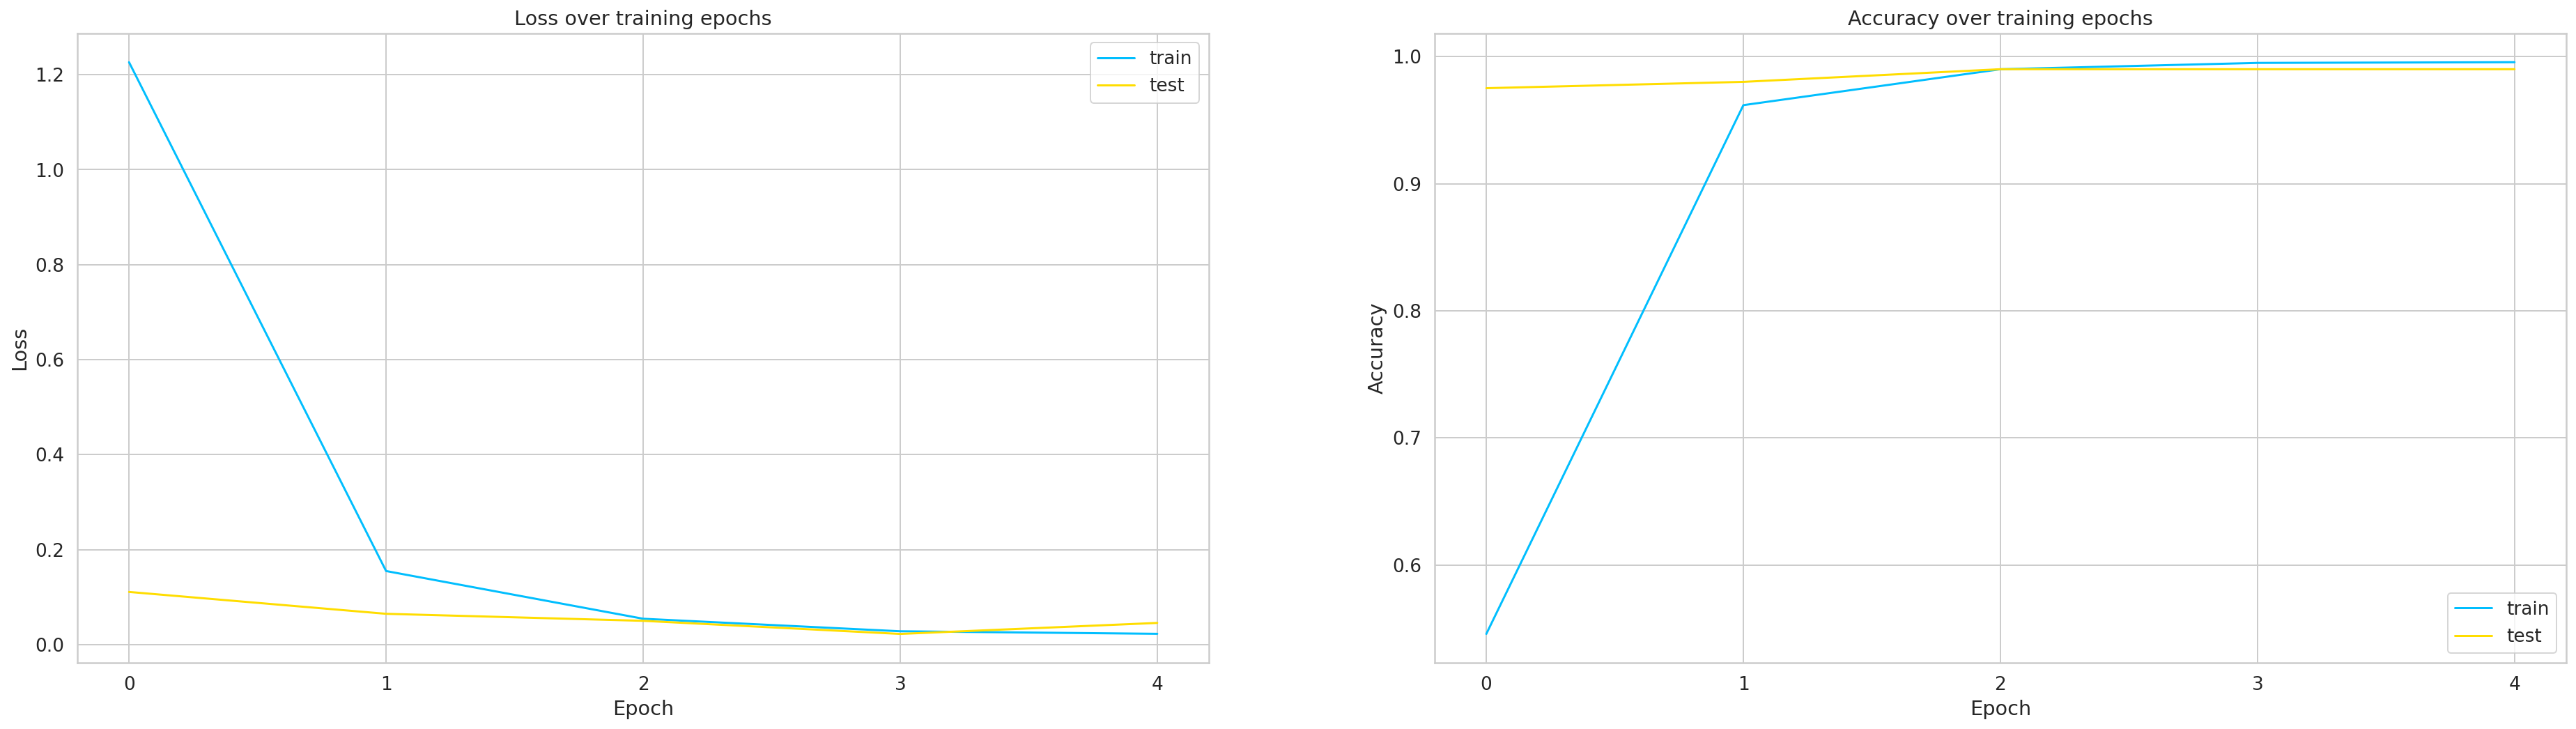

27/27 [==============================] - 2s 75ms/step - loss: 0.0242 - acc: 0.9953
train acc 0.9975074529647827
test acc 0.9953434467315674


In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(32, 8.3))
# how loss has decreased with epoch number 
ax = axes[0]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'test'])
ax.set_title('Loss over training epochs')
# graph for accuracy against the epoch number 
ax = axes[1]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train', 'test'])
ax.set_title('Accuracy over training epochs')
plt.show();
# evaluate the test accuracy , call evaluate method and give the data 
_, train_acc = bert_model.evaluate(data.train_x, data.train_y)
_, test_acc = bert_model.evaluate(data.test_x, data.test_y)
print("train acc", train_acc)
print("test acc", test_acc)

              precision    recall  f1-score   support

        food       0.99      1.00      0.99       144
    get help       1.00      1.00      1.00       102
   make call       0.99      1.00      1.00       149
out_of_scope       1.00      0.97      0.99       152
   send text       0.99      1.00      1.00       164
    visitors       1.00      1.00      1.00       148

    accuracy                           1.00       859
   macro avg       1.00      1.00      1.00       859
weighted avg       1.00      1.00      1.00       859



,text,predicted
0,Call the nurse please,get help
1,Can I get some tacos,food
2,Walk my dog,get help
3,Open the window,out_of_scope
4,Can you open the window,out_of_scope
5,I don't want tacos for lunch,food


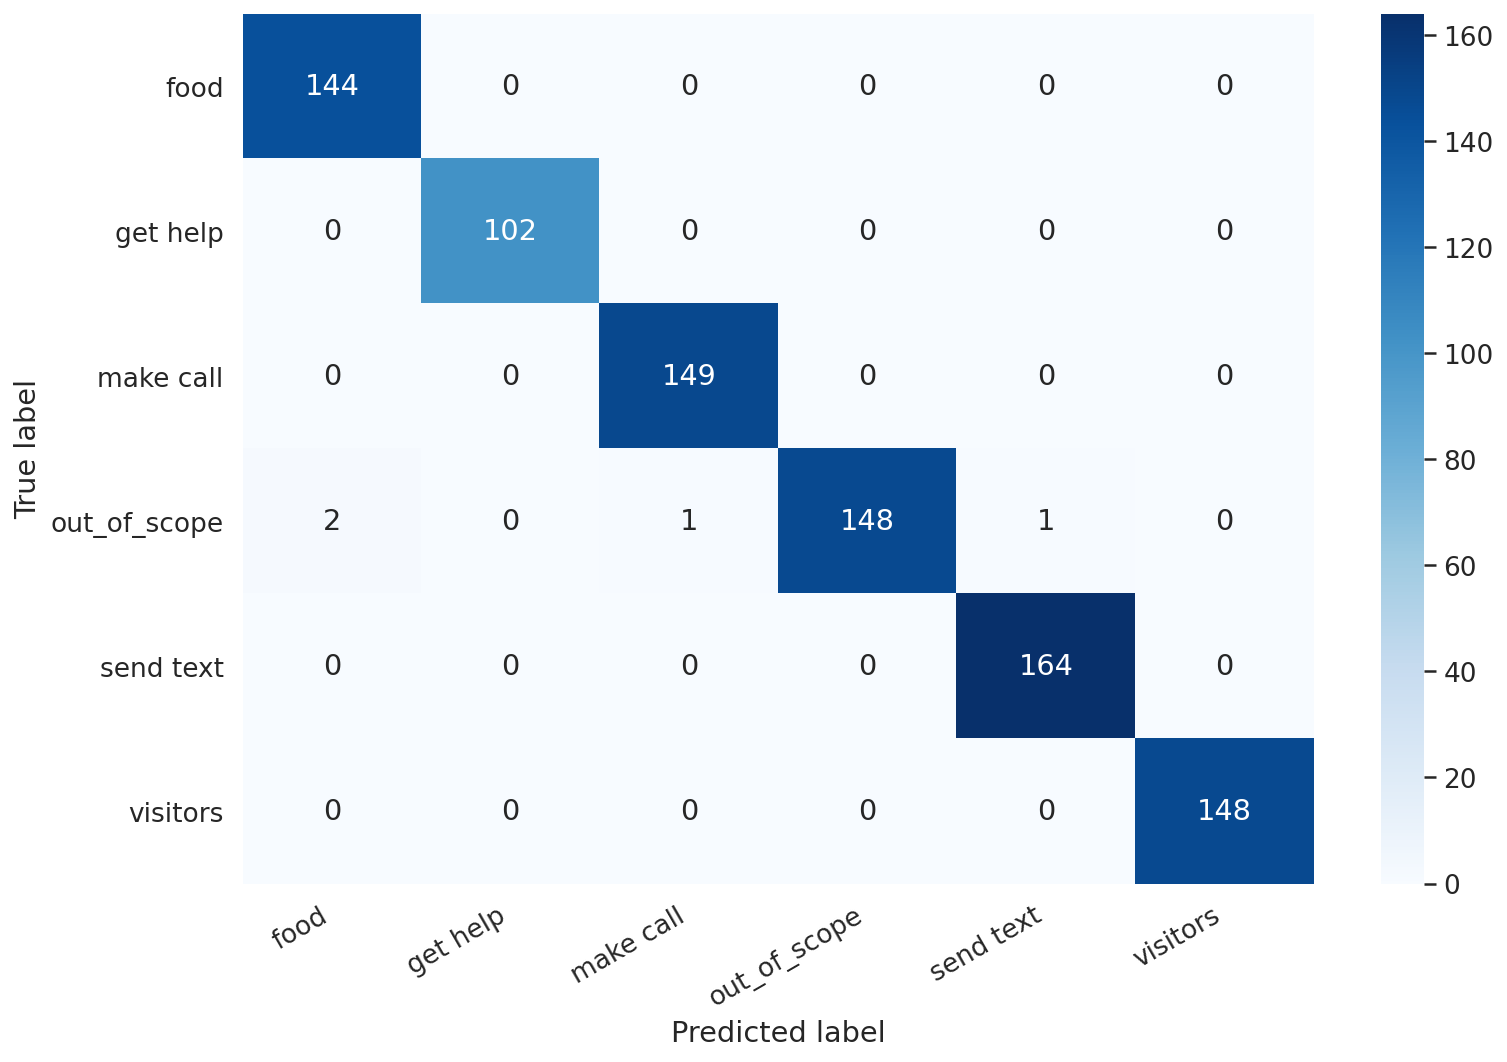

In [27]:
# take the class that is most likely to be the correct one based on model's opinion
y_pred = bert_model.predict(data.test_x).argmax(axis=-1)

# print classification report 
print(classification_report(data.test_y, y_pred, target_names=classes))
plot_confusion_matrix(data.test_y, y_pred, classes)

# trying a few sentences which the model has not seen 
sentences = np.array([
  "Call the nurse please",
  "Can I get some tacos",
  "Walk my dog",
  "Open the window", 
  "Can you open the window",
  "I don't want tacos for lunch"
], dtype=object)

predictions = get_bert_predictions(sentences, classes)
pd.DataFrame(np.c_[sentences, predictions], columns=['text', 'predicted'])

### Two-Stage (Bert + Bert)

Gating model for in v.s. out of class distribution classification

In [28]:
gate_data = IntentDetectionData(train_gate, test_gate, bert_tokenizer, classes_gate, max_seq_len=max_seq_len)
bert_gate = create_model(gate_data.max_seq_len, bert_ckpt_file, bert_config_file)
bert_gate.compile(
  # optimizer is Adam with learning rate 0.00001 ,  this is recommended by authors of bert model paper
  optimizer=keras.optimizers.Adam(1e-5),
  # using SparseCategoricalCrossentropy
  # because we have not used OneHotencoding here 
  loss=keras.losses.SparseCategoricalCrossentropy(),
  # specify the metrics from keras 
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

class_weights = generate_class_weights(gate_data.train_y, classes_gate)
# finally fit the model
history = bert_gate.fit(
  x=gate_data.train_x, 
  y=gate_data.train_y,
  # validation split to be 10% of the data 
  validation_split=0.1,
  # recommendation from authors , batch to be 16
  batch_size=16,
  # yes we want to shuffle 
  shuffle=True,
  # another recommendation from authors (epochs = 5)
  epochs=5,
  class_weight=class_weights, 
  # specify the call back 
  callbacks=[]
)

2006it [00:00, 4952.02it/s]
859it [00:00, 4530.72it/s]


Done loading 196 BERT weights from: /tmp/model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5a1df94d10> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
113/113 [==============================] - 37s 331ms/step - loss: 0.6564 - acc: 0.7003 - val_loss: 0.4494 - val_acc: 0.8458
Epoch 2/5
113/113 [==============================] - 35s 307ms/step - loss: 0.2023 - acc: 0.9352 - val_loss: 0.0497 - val_acc: 0.9751
Epoch 3/5
113/113 [==============================] - 35s 308ms/step - loss: 0.0903 - acc

Test accuracy: 1.00


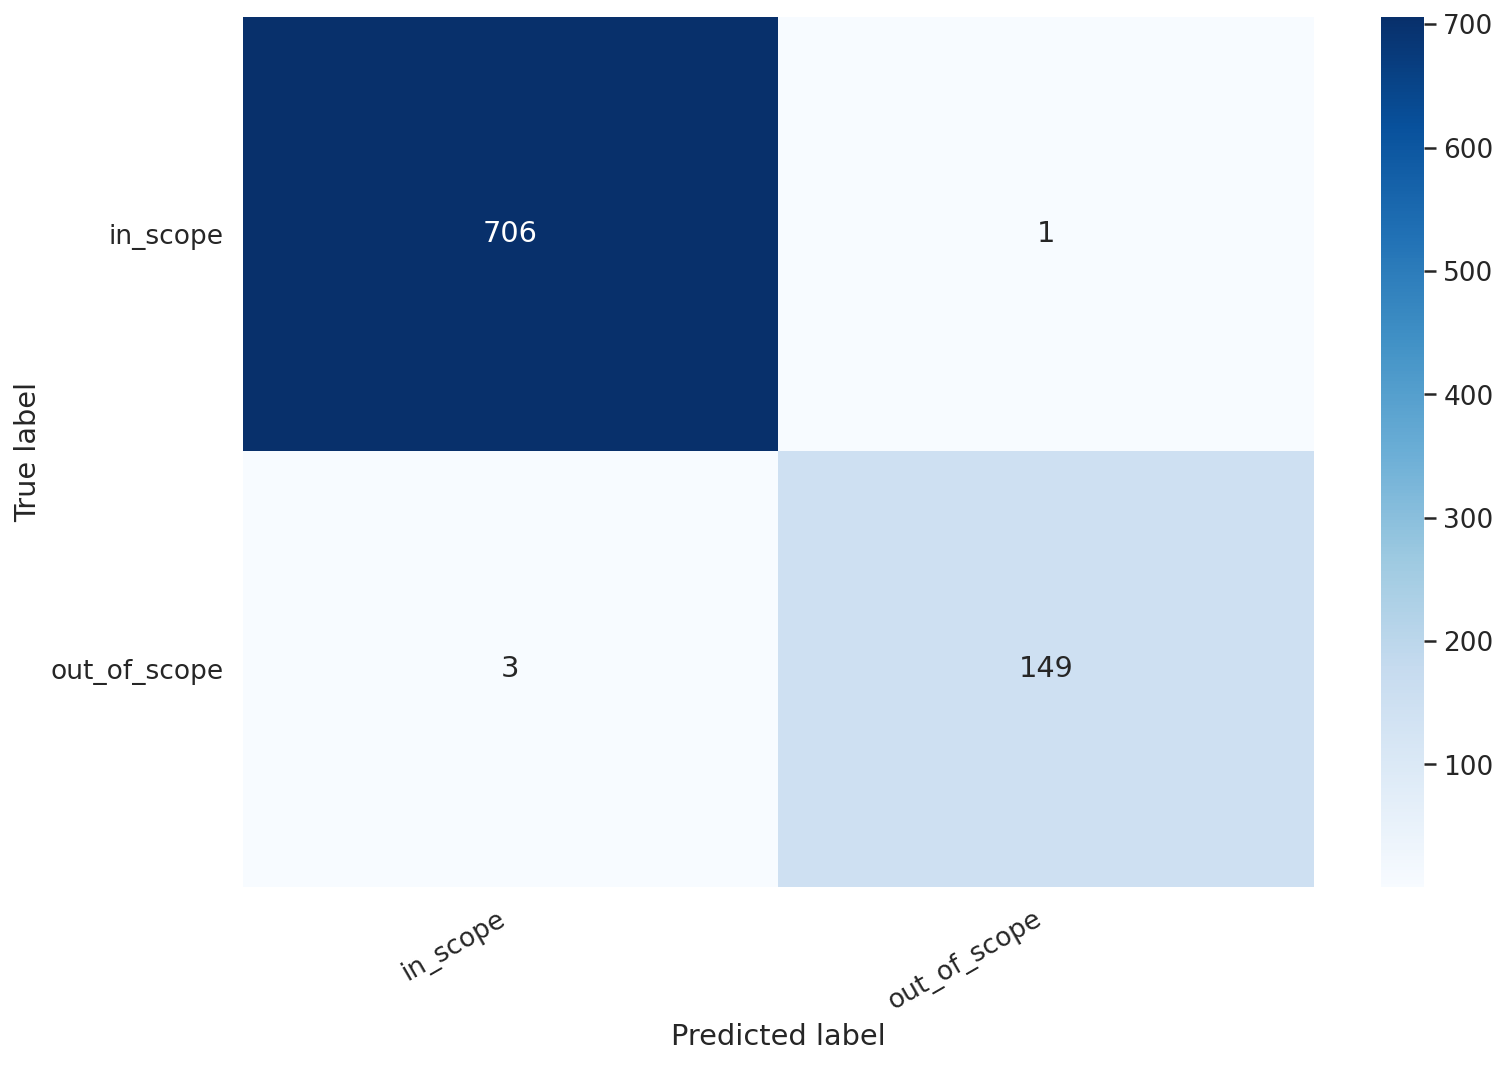

In [29]:
gate_pred = bert_gate.predict(gate_data.test_x).argmax(axis=-1)
plot_confusion_matrix(gate_data.test_y, gate_pred, classes=classes_gate)
print(f'Test accuracy: {accuracy_score(gate_data.test_y, gate_pred):.2f}')

In [30]:
bert_expert_data = IntentDetectionData(train_without_oos, test_without_oos, bert_tokenizer, classes_without_oos, max_seq_len=30)
bert_expert = create_model(bert_expert_data.max_seq_len, bert_ckpt_file, bert_config_file)
bert_expert.compile(
  # optimizer is Adam with learning rate 0.00001 ,  this is recommended by authors of bert model paper
  optimizer=keras.optimizers.Adam(1e-5),
  # using SparseCategoricalCrossentropy
  # because we have not used OneHotencoding here 
  loss=keras.losses.SparseCategoricalCrossentropy(),
  # specify the metrics from keras 
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

class_weights = generate_class_weights(bert_expert_data.train_y, classes_without_oos)

# finally fit the model
history = bert_expert.fit(
  x=bert_expert_data.train_x, 
  y=bert_expert_data.train_y,
  # validation split to be 10% of the data 
  validation_split=0.1,
  # recommendation from authors , batch to be 16
  batch_size=16,
  # yes we want to shuffle 
  shuffle=True,
  # another recommendation from authors (epochs = 5)
  epochs=5,
  class_weight = class_weights,
  # specify the call back 
  callbacks=[]
)

1658it [00:00, 4033.59it/s]
707it [00:00, 4156.01it/s]


Done loading 196 BERT weights from: /tmp/model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f599911cd10> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
94/94 [==============================] - 33s 348ms/step - loss: 1.1738 - acc: 0.5442 - val_loss: 0.0925 - val_acc: 0.9699
Epoch 2/5
94/94 [==============================] - 29s 308ms/step - loss: 0.1009 - acc: 0.9839 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 3/5
94/94 [==============================] - 29s 307ms/step - loss: 0.0222 - acc: 0.99

Test accuracy: 1.00


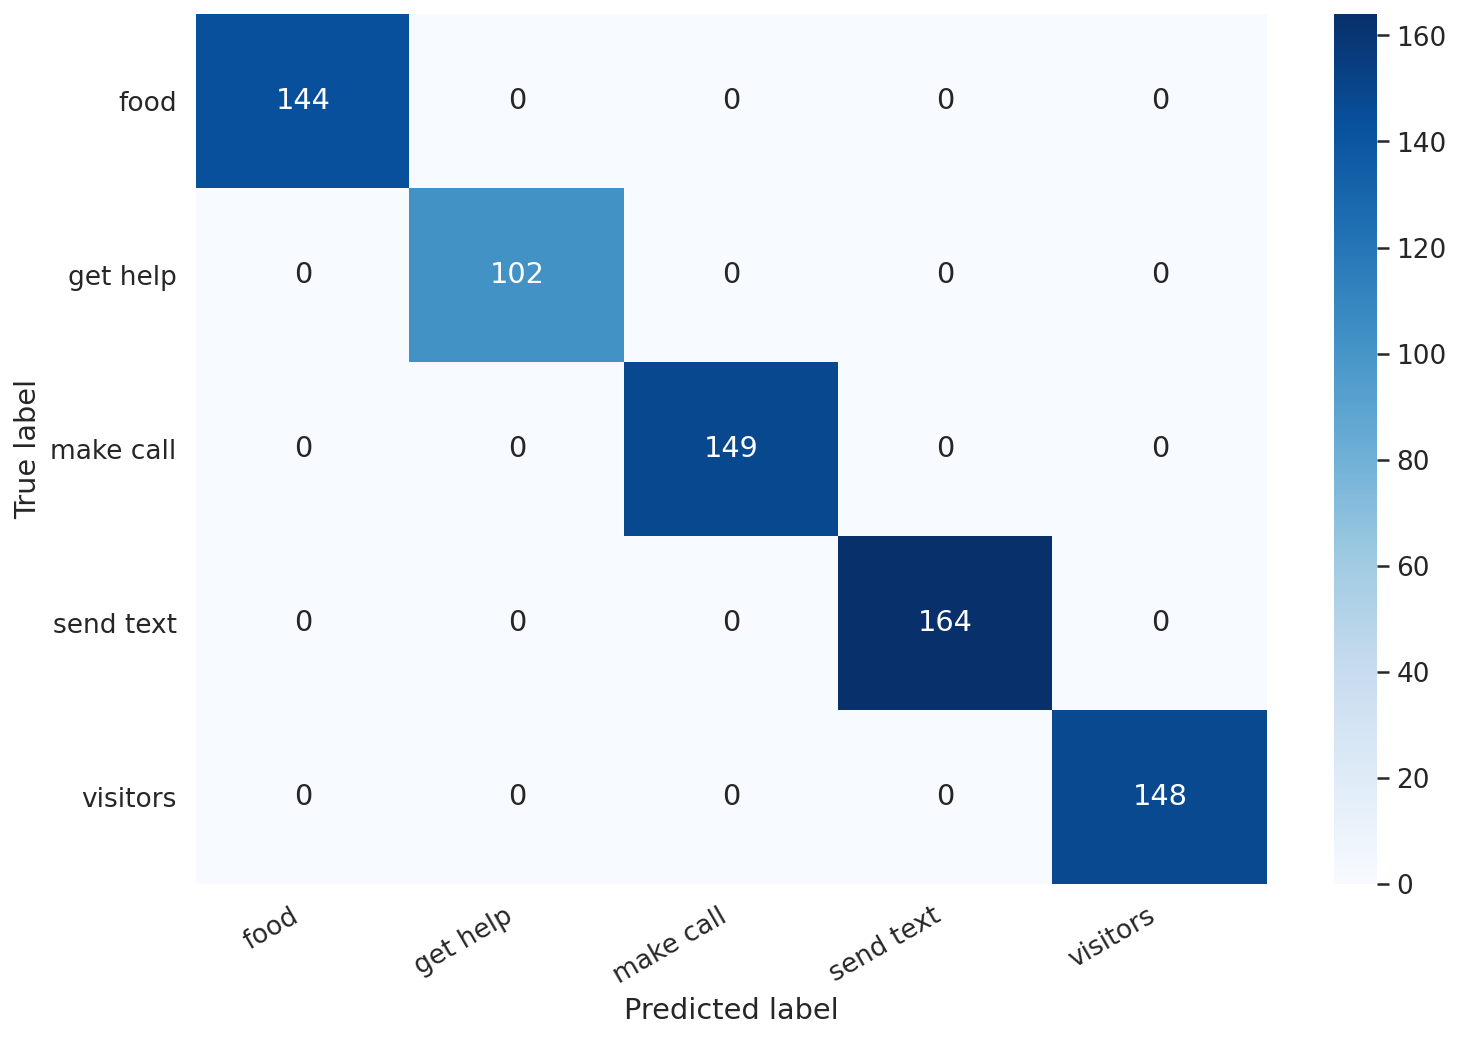

In [31]:
bert_expert_pred = bert_expert.predict(bert_expert_data.test_x).argmax(axis=-1)
plot_confusion_matrix(bert_expert_data.test_y, bert_expert_pred, classes=classes_without_oos)
print(f'Test accuracy: {accuracy_score(bert_expert_data.test_y, bert_expert_pred):.2f}')

Test accuracy: 1.00


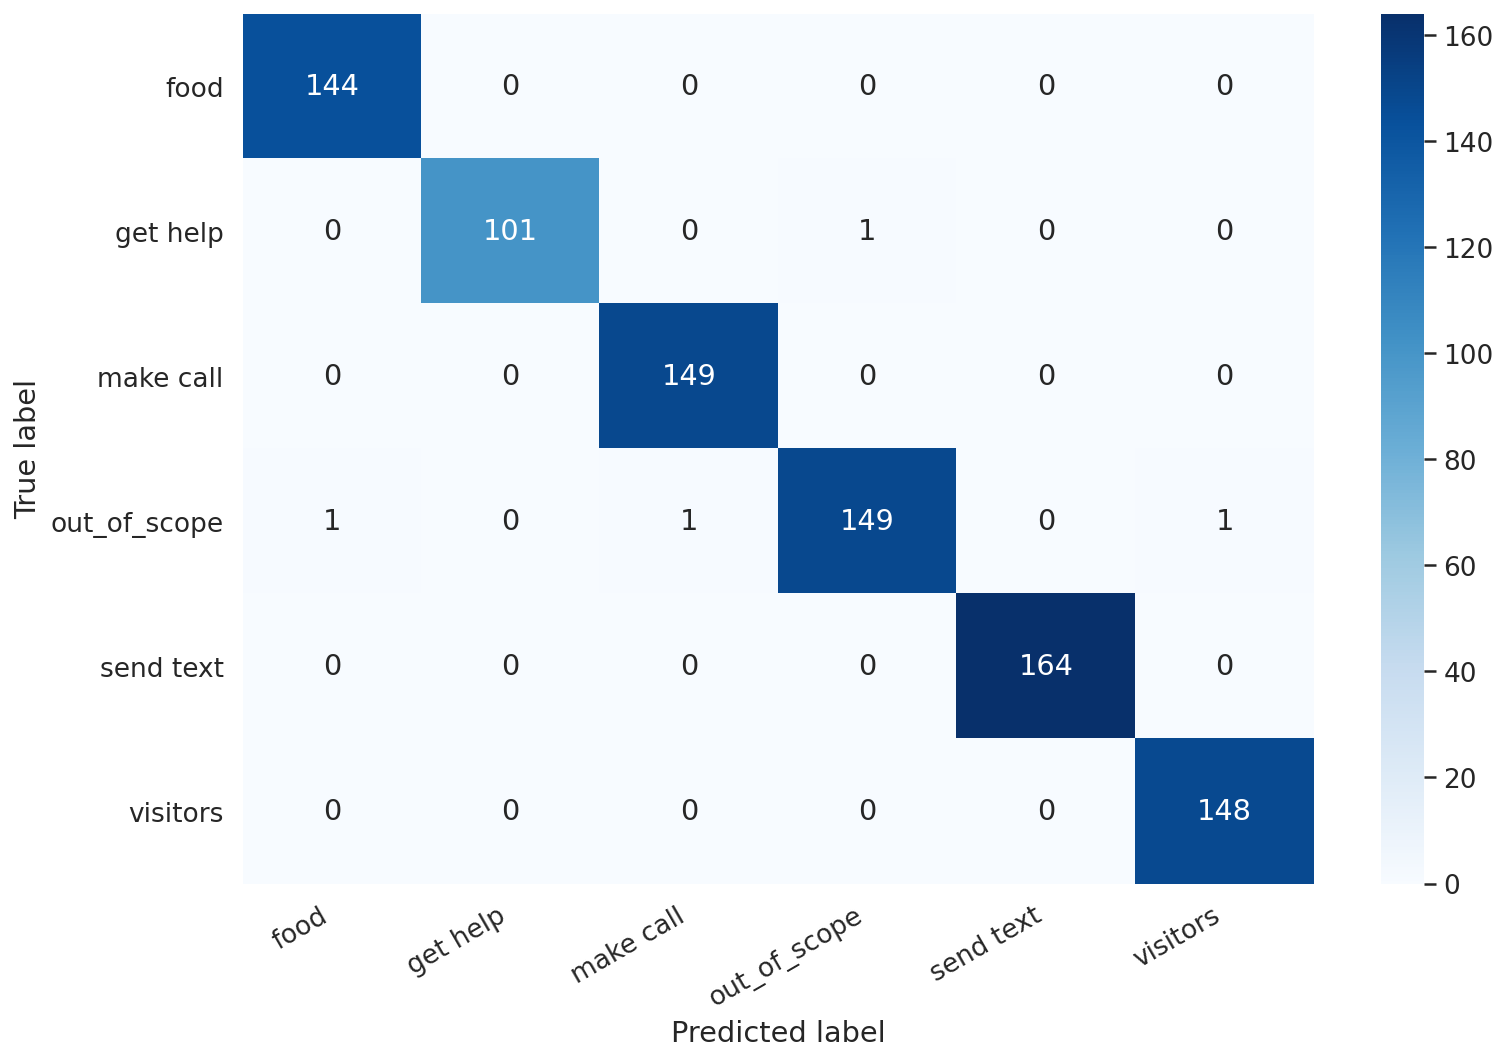

In [32]:
bert_expert_pred_all = bert_expert.predict(data.test_x).argmax(axis=-1)
df_bert_bert = pd.DataFrame(np.c_[gate_pred, bert_expert_pred_all, data.test_y], columns=['gate_pred', 'bert_expert_pred', 'actual'])
df_bert_bert['gate_pred'] = df_bert_bert['gate_pred'].apply(lambda x: classes_gate[x])
df_bert_bert['bert_expert_pred'] = df_bert_bert['bert_expert_pred'].apply(lambda x: classes_without_oos[x])
pred = np.empty(len(data.test_y), dtype=object)
for i, v in enumerate(df_bert_bert['bert_expert_pred']):
  if df_bert_bert['gate_pred'][i] != 'out_of_scope':
    pred[i] = v
  else:
    pred[i] = 'out_of_scope'
df_bert_bert['pred'] = pred
pred = df_bert_bert['pred'].apply(lambda x: classes.index(x))
plot_confusion_matrix(data.test_y, pred, classes=classes)
print(f'Test accuracy: {accuracy_score(data.test_y, pred):.2f}')

### Two-Stage (Bert + Sentence-Bert)

In [33]:
y_hat = np.empty(len(data.test_y), dtype=object)
for i in tqdm(range(len(y_hat)), position=0, leave=True):
  y_hat[i] = get_sentence_bert_predictions(test['text'].iloc[i], classes, sentence_bert_tokenizer, sentence_bert_model)

100%|██████████| 859/859 [02:33<00:00,  5.60it/s]


Test accuracy: 0.70


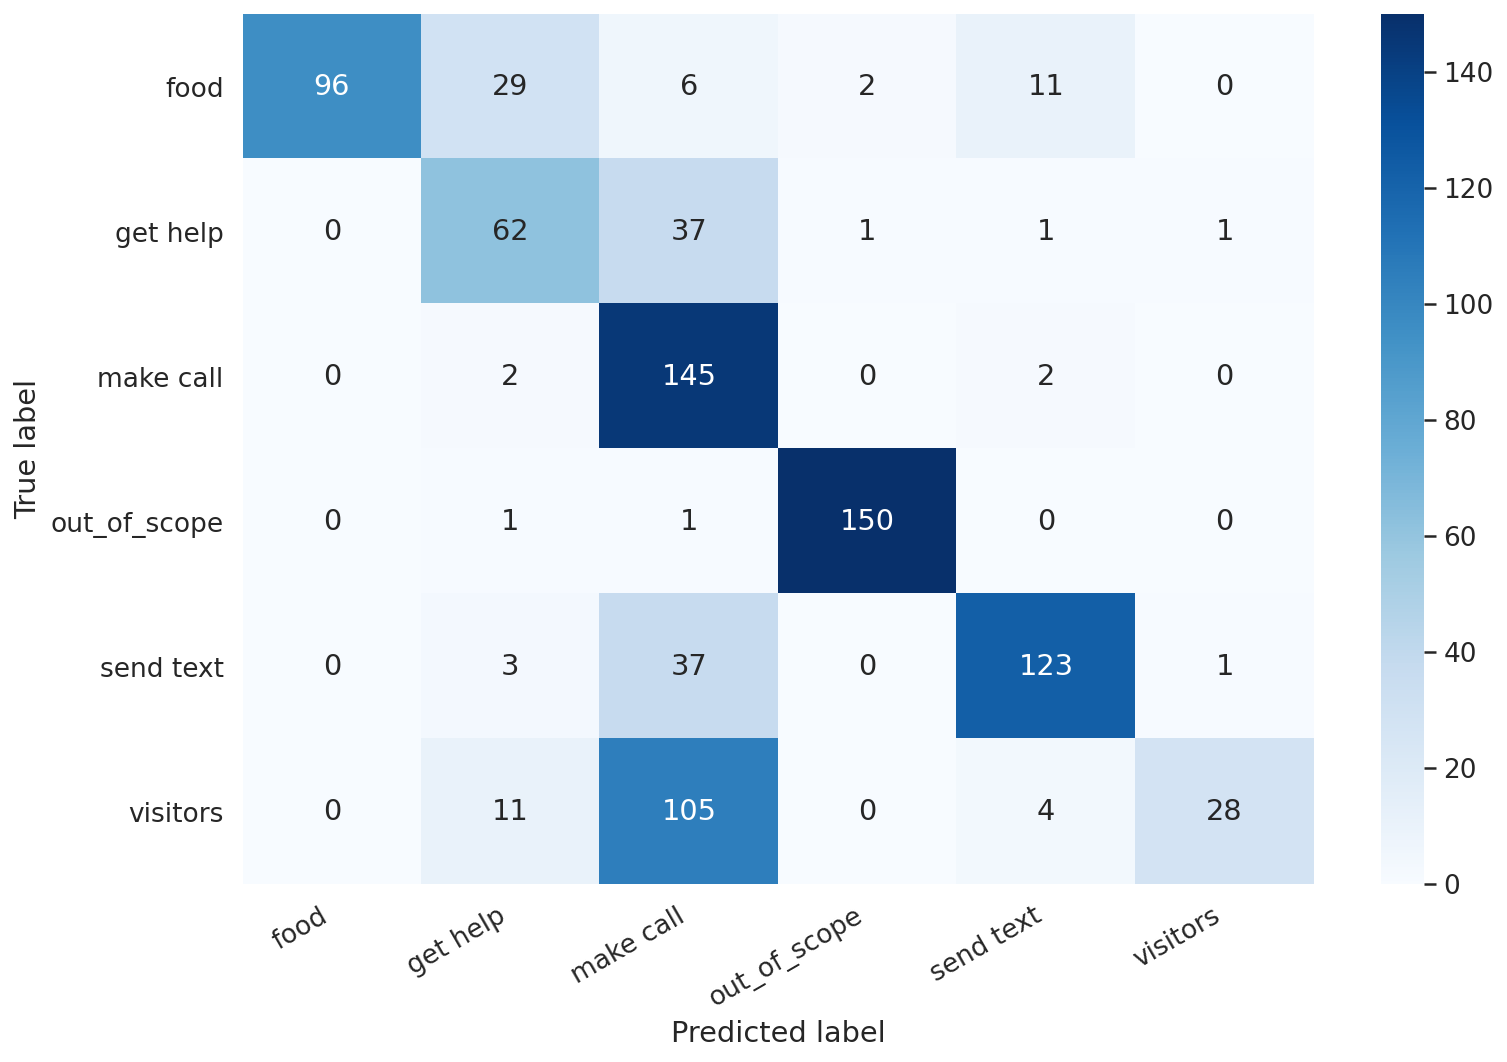

In [34]:
df_bert_sentence = pd.DataFrame(np.c_[gate_pred, y_hat, data.test_y], columns=['gate_pred', 'sentence_bert', 'actual'])
df_bert_sentence['gate_pred'] = df_bert_sentence['gate_pred'].apply(lambda x: classes_gate[x])
pred = np.empty(len(data.test_y), dtype=object)
for i, v in enumerate(df_bert_sentence['sentence_bert']):
  if df_bert_bert['gate_pred'][i] != 'out_of_scope':
    pred[i] = v
  else:
    pred[i] = 'out_of_scope'
df_bert_sentence['pred'] = pred
pred = df_bert_sentence['pred'].apply(lambda x: classes.index(x))
plot_confusion_matrix(data.test_y, pred, classes=classes)
print(f'Test accuracy: {accuracy_score(data.test_y, pred):.2f}')

### Two-Stage (Bert + Bart-Large)


In [35]:
dataset = tf.data.Dataset.from_tensor_slices(test['text'])
batch_size = 60
num_batch = dataset.batch(batch_size=batch_size).cardinality().numpy()
y_hat = np.zeros([num_batch], dtype=object)

In [36]:
for i, batch in enumerate(tqdm(dataset.batch(batch_size=batch_size), position=0)):
  input = list(map(lambda x: x.decode('utf-8'), batch.numpy()))
  y_hat[i] = np.array([pred['labels'][0] for pred in get_bart_large_predictions(input, classes, bart_large_tokenizer, bart_large_model)])
y_hat =  np.concatenate(y_hat)

100%|██████████| 15/15 [16:08<00:00, 64.55s/it]


Test accuracy: 0.89


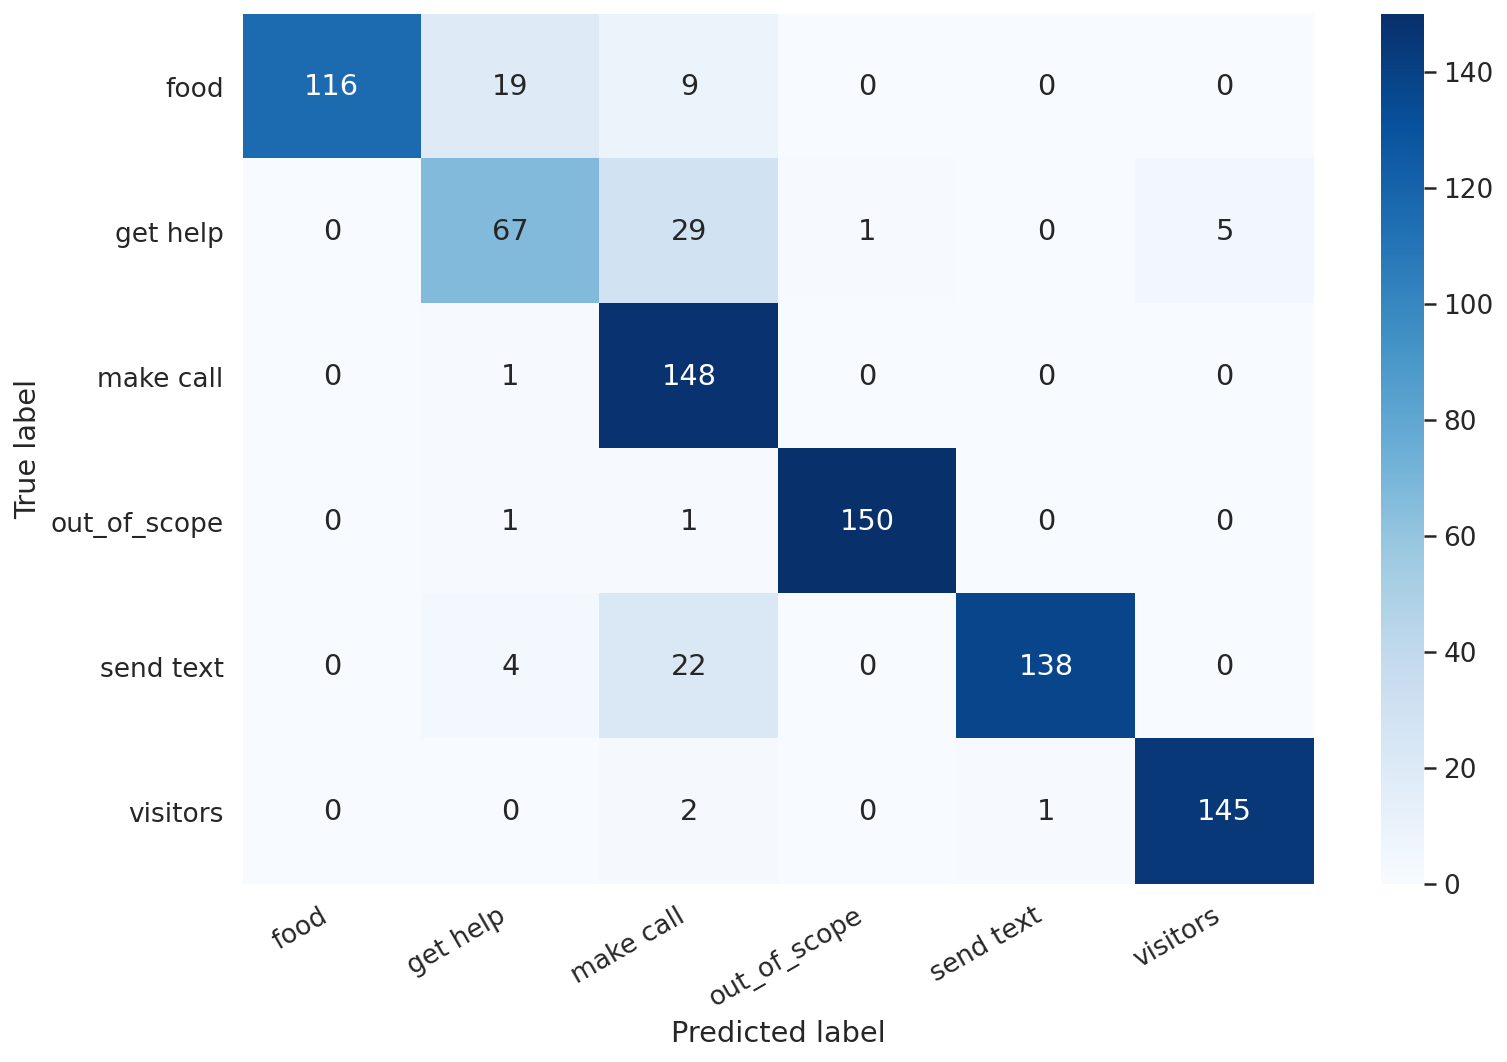

In [37]:
df_bert_bart = pd.DataFrame(np.c_[gate_pred, y_hat, data.test_y], columns=['gate_pred', 'bert_bart', 'actual'])
df_bert_bart['gate_pred'] = df_bert_bert['gate_pred']
pred = np.empty(len(data.test_y), dtype=object)
for i, v in enumerate(df_bert_bart['bert_bart']):
  if df_bert_bert['gate_pred'][i] != 'out_of_scope':
    pred[i] = v
  else:
    pred[i] = 'out_of_scope'
df_bert_bart['pred'] = pred
pred = df_bert_bart['pred'].apply(lambda x: classes.index(x))
plot_confusion_matrix(data.test_y, pred, classes=classes)
print(f'Test accuracy: {accuracy_score(data.test_y, pred):.2f}')

### Save the best model

In [38]:
bert_model.save('./models/Bert.h5') 